In [1]:
from utils import Logger,adjust_learning_rate,CreateLogger,create_cosine_learning_schedule,encode_test_label,set_seed
from model import Resnet_with_uncertainty, MLP_with_uncertainty#不确定度
from dependency import *
from torch import optim
from torchcontrib.optim import SWA
from dataloader import generate_dataloader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error # 均方误差
from tensorflow.keras.utils import to_categorical
import pandas as pd
from dependency import *
%matplotlib notebook

In [2]:
from model import Resnet_with_uncertainty,MyCNN,ResNet50_uncertainty,MLP_with_uncertainty_all
from second_stage_fusion_utils_concat2 import predict,predict3
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error 
import numpy as np
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib notebook

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:05<00:00, 72.78it/s]


In [3]:
import torch.nn.functional as F
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import roc_auc_score,accuracy_score, roc_curve,auc,average_precision_score,precision_recall_curve
import cv2
from dependency import *
import pandas as pd
from utils import encode_test_label,Logger,encode_meta_choosed_label,encode_meta_label
from tqdm import tqdm_notebook  

test_index_df = pd.read_csv(test_index_path)
train_index_df = pd.read_csv(train_index_path)
val_index_df = pd.read_csv(val_index_path)

train_index_list = list(train_index_df['indexes'])
val_index_list = list(val_index_df['indexes'])
test_index_list = list(test_index_df['indexes'])

train_index_list_1 = train_index_list[0:206]
train_index_list_2 = train_index_list[206:]

df = pd.read_csv(img_info_path)

In [4]:
def get_label_list(image_index_list):
    diag_label_list = []
    pn_label_list = []
    str_label_list = []
    pig_label_list = []
    rs_label_list = []
    dag_label_list = []
    bwv_label_list = []
    vs_label_list = []
    meta_list = []
    meta_list_one_hot = []
    
    img_feature = []
    img_hf_feature = []
    img_vf_feature = []
    img_vhf_feature = []

    from sklearn.decomposition import PCA

    from tqdm import tqdm_notebook,tqdm
    for index_num in tqdm(image_index_list):
    #index_num = test_index_list[100]
        img_info = df[index_num:index_num+1]
        clinic_path = img_info['clinic']
        dermoscopy_path = img_info['derm']
        source_dir = '../release_v0/release_v0/images/'
        clinic_img = cv2.imread(source_dir+clinic_path[index_num])
        dermoscopy_img = cv2.imread(source_dir+dermoscopy_path[index_num])
        '''这里对于metadata需要变更'''
        meta_vector_one_hot,meta_vector = encode_meta_label(img_info,index_num)
        
        [diagnosis_label,pigment_network_label,streaks_label,pigmentation_label,regression_structures_label,
         dots_and_globules_label,blue_whitish_veil_label, vascular_structures_label],[diagnosis_label_one_hot,pigment_network_label_one_hot,
        streaks_label_one_hot,pigmentation_label_one_hot,regression_structures_label_one_hot,
        dots_and_globules_label_one_hot,blue_whitish_veil_label_one_hot, vascular_structures_label_one_hot] = encode_test_label(img_info,index_num)

        diag_label_list.append(diagnosis_label)
        pn_label_list.append(pigment_network_label)
        str_label_list.append(streaks_label)
        pig_label_list.append(pigmentation_label)
        rs_label_list.append(regression_structures_label)
        dag_label_list.append(dots_and_globules_label)
        bwv_label_list.append(blue_whitish_veil_label)
        vs_label_list.append(vascular_structures_label)
        meta_list.append(meta_vector)
        meta_list_one_hot.append(meta_vector_one_hot)



    label_dict ={'diag':diag_label_list,
                 'pn':pn_label_list,
                 'str':str_label_list,
                 'pig':pig_label_list,
                 'rs':rs_label_list,
                 'dag':dag_label_list,
                 'bwv':bwv_label_list,
                 'vs':vs_label_list}
    
    return label_dict,meta_list,meta_list_one_hot

# multi-modality with uncertainty(derm, clinic, and all metadata) fusion here

./multimodal(copy2)_Resnet_cos-loss and concat_Normal_weight_file/4/checkpoint/best_mean_acc_model.pth
./multimodal_MLP-all-metadata_Normal_weight_file/4/checkpoint/best_mean_acc_model.pth
P1--------------------------------on images

--- [START IDENTIFIER] ----------------------------------------------------------------




100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:51<00:00,  7.72it/s]


---------------

avg_acc : 0.7481012658227848

vs_acc : 0.8177215189873418

bwv_acc : 0.8759493670886076

dag_acc : 0.6455696202531646

rs_acc : 0.7949367088607595

pig_acc : 0.7164556962025317

str_acc : 0.7468354430379747

pn_acc : 0.6759493670886076

diag_acc : 0.7113924050632912

---------------

nevu_auc: 0.9046025321710253

bcc_auc: 0.9211741424802111

mel_auc: 0.8942210547585371

misc_auc: 0.8921126760563379

sk_auc: 0.7466405375139977

---------------

vs_asb_auc: 0.8751655887165901

vs_reg_auc: 0.8552366001345594

vs_irg_auc: 0.8388127853881279

---------------

bwv_asb_auc: 0.91625

bwv_prs_auc: 0.91625

---------------

dag_asb_auc: 0.7917627118644067

dag_reg_auc: 0.7975279936364191

dag_irg_auc: 0.8162286839786451

---------------

rs_asb_auc: 0.8604491741202586

rs_prs_auc: 0.8604491741202586

---------------

pig_asb_auc: 0.8146574199603711

pig_reg_auc: 0.813640730067243

pig_irg_auc: 0.839156052850851

---------------

str_asb_auc: 0.8534934867196753

str_reg_auc: 0.87

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:46<00:00,  8.52it/s]


---------------

avg_acc : 0.7607594936708861

vs_acc : 0.7974683544303798

bwv_acc : 0.8860759493670886

dag_acc : 0.6759493670886076

rs_acc : 0.8151898734177215

pig_acc : 0.6886075949367089

str_acc : 0.7468354430379747

pn_acc : 0.7215189873417721

diag_acc : 0.7544303797468355

---------------

nevu_auc: 0.933815898713159

bcc_auc: 0.9447559366754618

mel_auc: 0.9383040344850812

misc_auc: 0.9315492957746478

sk_auc: 0.9217525195968646

---------------

vs_asb_auc: 0.854632587859425

vs_reg_auc: 0.8382484862076699

vs_irg_auc: 0.8231963470319634

---------------

bwv_asb_auc: 0.9382083333333333

bwv_prs_auc: 0.9382083333333334

---------------

dag_asb_auc: 0.8041016949152543

dag_reg_auc: 0.8349140304717616

dag_irg_auc: 0.8623075726947598

---------------

rs_asb_auc: 0.8604165306522166

rs_prs_auc: 0.8604165306522166

---------------

pig_asb_auc: 0.8199238711023047

pig_reg_auc: 0.8504442843419788

pig_irg_auc: 0.8530234495893346

---------------

str_asb_auc: 0.8634466813285

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:46<00:00,  8.54it/s]


<IPython.core.display.Javascript object>


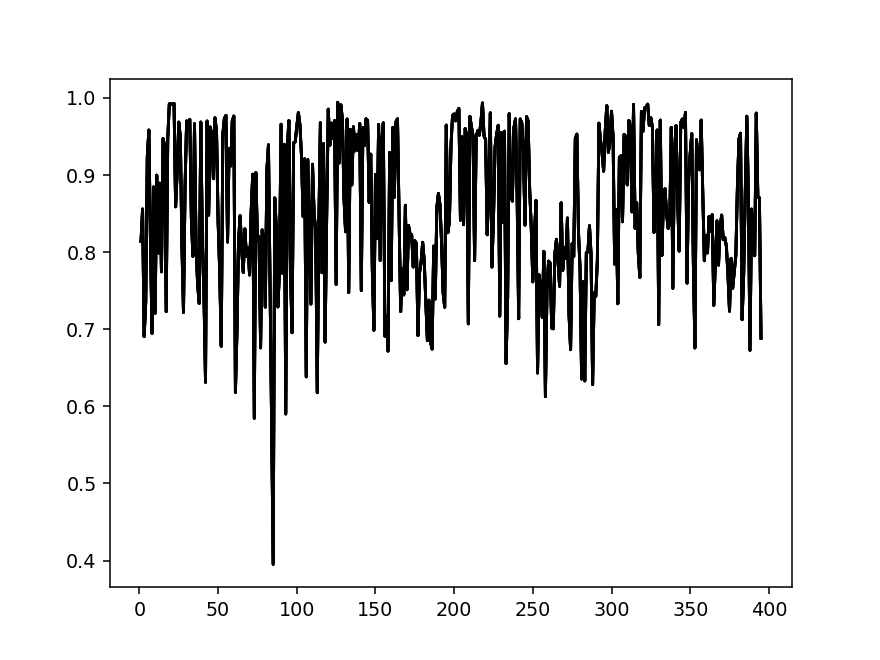

---------------

avg_acc : 0.7629746835443039

vs_acc : 0.7974683544303798

bwv_acc : 0.8886075949367088

dag_acc : 0.6784810126582278

rs_acc : 0.8126582278481013

pig_acc : 0.6936708860759494

str_acc : 0.7518987341772152

pn_acc : 0.7215189873417721

diag_acc : 0.759493670886076

---------------

nevu_auc: 0.9339715649647157

bcc_auc: 0.9452506596306068

mel_auc: 0.9378662356031522

misc_auc: 0.9297887323943662

sk_auc: 0.9172732362821948

---------------

vs_asb_auc: 0.8541260811969144

vs_reg_auc: 0.8354451670778202

vs_irg_auc: 0.8239269406392695

---------------

bwv_asb_auc: 0.9381249999999999

bwv_prs_auc: 0.938125

---------------

dag_asb_auc: 0.8041016949152541

dag_reg_auc: 0.8375451263537905

dag_irg_auc: 0.8633183019748095

---------------

rs_asb_auc: 0.8582294182933995

rs_prs_auc: 0.8582294182933995

---------------

pig_asb_auc: 0.8173167170716447

pig_reg_auc: 0.8398174831892411

pig_irg_auc: 0.8508510891560529

---------------

str_asb_auc: 0.8614165679806012

str_

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:46<00:00,  8.49it/s]


---------------

avg_acc : 0.7615506329113925

vs_acc : 0.7974683544303798

bwv_acc : 0.8886075949367088

dag_acc : 0.6784810126582278

rs_acc : 0.8126582278481013

pig_acc : 0.6949367088607595

str_acc : 0.7417721518987341

pn_acc : 0.7164556962025317

diag_acc : 0.7620253164556962

---------------

nevu_auc: 0.9332580946450809

bcc_auc: 0.9462813324538257

mel_auc: 0.9369653802114906

misc_auc: 0.9293485915492958

sk_auc: 0.9140187569988801

---------------

vs_asb_auc: 0.8588794514143223

vs_reg_auc: 0.8392436644987665

vs_irg_auc: 0.8269406392694064

---------------

bwv_asb_auc: 0.9385416666666665

bwv_prs_auc: 0.9385416666666666

---------------

dag_asb_auc: 0.8044067796610169

dag_reg_auc: 0.8369791347977726

dag_irg_auc: 0.8612579692116312

---------------

rs_asb_auc: 0.8631830645687798

rs_prs_auc: 0.8631830645687798

---------------

pig_asb_auc: 0.817701272291167

pig_reg_auc: 0.8372658501440923

pig_irg_auc: 0.8522497321747412

---------------

str_asb_auc: 0.865448598657

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:47<00:00,  8.30it/s]


---------------

avg_acc : 0.7620253164556963

vs_acc : 0.7974683544303798

bwv_acc : 0.8886075949367088

dag_acc : 0.6784810126582278

rs_acc : 0.8126582278481013

pig_acc : 0.6945147679324895

str_acc : 0.7451476793248946

pn_acc : 0.7181434599156118

diag_acc : 0.7611814345991561

---------------

nevu_auc: 0.9335074489184079

bcc_auc: 0.9458553210202286

mel_auc: 0.937271278148223

misc_auc: 0.9295070422535211

sk_auc: 0.9148780639542118

---------------

vs_asb_auc: 0.85729932379196

vs_reg_auc: 0.8379183175101542

vs_irg_auc: 0.8258751902587519

---------------

bwv_asb_auc: 0.9384212962962963

bwv_prs_auc: 0.9384212962962962

---------------

dag_asb_auc: 0.8042862523540489

dag_reg_auc: 0.8371677986497786

dag_irg_auc: 0.8619677833641448

---------------

rs_asb_auc: 0.861602576657744

rs_prs_auc: 0.8616025766577442

---------------

pig_asb_auc: 0.8176150913662646

pig_reg_auc: 0.8396440388515318

pig_irg_auc: 0.8517339205650122

---------------

str_asb_auc: 0.864176644924403

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:46<00:00,  8.51it/s]


---------------

avg_acc : 0.7622626582278481

vs_acc : 0.7974683544303798

bwv_acc : 0.8886075949367088

dag_acc : 0.6778481012658227

rs_acc : 0.8126582278481013

pig_acc : 0.6962025316455697

str_acc : 0.7462025316455696

pn_acc : 0.7183544303797469

diag_acc : 0.760759493670886

---------------

nevu_auc: 0.9336018576172685

bcc_auc: 0.9454052605540897

mel_auc: 0.9374452751397588

misc_auc: 0.929568661971831

sk_auc: 0.9151648236282195

---------------

vs_asb_auc: 0.8569703109171667

vs_reg_auc: 0.8372988618524333

vs_irg_auc: 0.8258675799086759

---------------

bwv_asb_auc: 0.9385598958333333

bwv_prs_auc: 0.9385598958333333

---------------

dag_asb_auc: 0.8042775423728814

dag_reg_auc: 0.8373022853821208

dag_irg_auc: 0.8621520758824444

---------------

rs_asb_auc: 0.8609694293921786

rs_prs_auc: 0.8609694293921787

---------------

pig_asb_auc: 0.8178935499009281

pig_reg_auc: 0.8392621277617676

pig_irg_auc: 0.8518089364361385

---------------

str_asb_auc: 0.8632827919697

In [5]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
seed = 0
mode = 'multimodal(copy2)'
model_name = 'Resnet_cos-loss and concat'
import random
random.seed(seed)
TTA = 6
img_type="concat"
size = 229
data_mode = 'Normal'

p1_acc_list = []
p2_acc_list = []
p3_acc_list = []

#change i here!
i = 4

mean_avg_acc_list = []

weight_file = './{}_{}_{}_weight_file/{}/checkpoint/best_mean_acc_model.pth'.format(mode,model_name,data_mode,i)
print(weight_file)

net = Resnet_with_uncertainty(class_list).cuda()
net.load_state_dict(torch.load(weight_file))

weight_file2 = './{}_{}_{}_weight_file/{}/checkpoint/best_mean_acc_model.pth'.format("multimodal","MLP-all-metadata",data_mode,i)
print(weight_file2)

net2 =  MLP_with_uncertainty_all(class_list).cuda()

net2.load_state_dict(torch.load(weight_file2))
print("P1--------------------------------on images")
out_dir = './{}_{}_{}_result/{}/'.format(mode,model_name,"MLP-all-metadata","P1")
(avg_acc,uncertainty_pred,
     [prob,pn_prob,str_prob,pig_prob,rs_prob,dag_prob,bwv_prob,vs_prob], 
     [nevu_label, bcc_label, mel_label, misc_label, sk_label],
     [nevu_prob ,bcc_prob ,  mel_prob ,misc_prob ,sk_prob],
     seven_point_feature_list,
     [gt,pn_gt,str_gt,pig_gt,rs_gt,dag_gt, bwv_gt,vs_gt] )= predict(net2,net,test_index_list,df,
                                                                    model_name,out_dir,mode,TTA,size,img_type,"img")
print("P2--------------------------------on metadata")
out_dir = './{}_{}_{}_result/{}/'.format(mode,model_name,"MLP-all-metadata","P2")
(avg_acc,uncertainty_pred,
     [prob,pn_prob,str_prob,pig_prob,rs_prob,dag_prob,bwv_prob,vs_prob], 
     [nevu_label, bcc_label, mel_label, misc_label, sk_label],
     [nevu_prob ,bcc_prob ,  mel_prob ,misc_prob ,sk_prob],
     seven_point_feature_list,
     [gt,pn_gt,str_gt,pig_gt,rs_gt,dag_gt, bwv_gt,vs_gt] )= predict(net2,net,test_index_list,df,
                                                                    model_name,out_dir,mode,TTA,size,img_type,"metadata")
prob_2 = prob
pn_prob_2 = pn_prob
str_prob_2 = str_prob
pig_prob_2 = pig_prob
rs_prob_2 = rs_prob
dag_prob_2 = dag_prob
bwv_prob_2 = bwv_prob
vs_prob_2 = vs_prob
uncertainty_2 = uncertainty_pred
p2_list  = [prob_2,pn_prob_2,str_prob_2,pig_prob_2,rs_prob_2,dag_prob_2,bwv_prob_2,vs_prob_2,uncertainty_2]
print("P2 Done")

print("(clinic, derm)-concat & metadata fusion here!------------------------------------------------")
out_dir = './{}_{}_{}_result/{}/'.format(mode,model_name,"MLP-all-metadata","P3")
(avg_acc,
     [prob,pn_prob,str_prob,pig_prob,rs_prob,dag_prob,bwv_prob,vs_prob], 
     [nevu_label, bcc_label, mel_label, misc_label, sk_label],
     [nevu_prob ,bcc_prob ,  mel_prob ,misc_prob ,sk_prob],
     seven_point_feature_list,
     [gt,pn_gt,str_gt,pig_gt,rs_gt,dag_gt, bwv_gt,vs_gt] )= predict3(net,net2,test_index_list,df,model_name,out_dir,mode,TTA,size,img_type)
